In [12]:
import sys

In [20]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
import torch
from nwnTorch.misc import *
import matplotlib.pyplot as plt

In [ ]:
# -*- coding: utf-8 -*-
"""
Python 2.7
Created on Wed Dec 23 20:36:43 2020
@author: Xinyu HAN
"""

import numpy as np
import pandas as pd
from scipy import special, stats
from tools import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
    
# reservoir computing
class reservoir_computing():
    def __init__(self,N=3,Dr=300, rho=1,delta=0.1,b=0,transient=1000,R_network=None,W_in=None):
        """
        L: 
        N: the input dimension
        Dr: the reservoir network size
        rho: spectral radius of the reservoir network weight matrix
        delta: the scaling parameter of the input-to-reservoir matrix
        b: the bias term
        transient: the number of reservoir state data  to be deleted  
        
        R_network: the reservoir network weight matrix
        W_in : the input-to-reservoir matrix
        """
        self.N=N
        self.Dr=Dr
        self.rho=rho
        self.delta=delta
        self.b=b
        self.transient=transient
        
        self.R_network=R_network
        self.W_in=W_in
        
    
    def Training_phase(self, train_data=None,Train_expect=None,index_method=0):
        L=train_data.shape[0]
        R_state = np.zeros((L, self.Dr))
        W_out= np.zeros((self.Dr, self.N))
        Pre_train_output= np.zeros((L, self.N))
         
        R_state[0,:]=np.tanh(np.dot(self.rho*self.R_network, R_state[0,:])
                             +self.delta*np.dot(self.W_in,train_data[0,:])+self.b)
        for i in range(1,L):
            R_state[i,:]=np.tanh(np.dot(self.rho*self.R_network, R_state[i-1,:])
                         +self.delta*np.dot(self.W_in,train_data[i,:])+self.b)
        
        W_out=traing_Wout(Train_expect[self.transient:,:],R_state[self.transient:,:],index=index_method,k=0.8)
#        print(W_out.shape)
        
        Pre_train_output=np.dot(R_state,W_out)
         
        self.W_out=W_out
        self.laststate=R_state[-1,:]
        self.lastinput=Train_expect[-1,:]
         
        return Pre_train_output#,W_out,R_state
    
    def Predicting_phase(self,Pre_L=100):
 
        outputs=np.zeros((Pre_L,self.N))
        R_state=np.zeros((Pre_L,self.Dr))
        
        R_state[0,:]=np.tanh((np.dot(self.rho*self.R_network,self.laststate)
                             +self.delta*np.dot(self.W_in,self.lastinput)+self.b))
        outputs[0,:]=np.dot(R_state[0, :],self.W_out,)
        for i in range(1,Pre_L):
            R_state[i, :] = np.tanh(np.dot(self.rho*self.R_network, R_state[i-1,:])
                             +self.delta*np.dot(self.W_in,outputs[i-1,:])+self.b)
            
            outputs[i, :] = np.dot(R_state[i, :],self.W_out)
            
        return outputs

In [69]:
class Reservoir():
    # def __init__(self,N=3,Dr=300, rho=1,delta=0.1,b=0,transient=1000,R_network=None,W_in=None):

    def __init__(self, N, W_net = None, W_in = None):
        self.params = {
            "delta": 0.1,
            "b"    : 0,
                       }
        
        self.N           = N
        self.W_net       = W_net
        self.W_in        = W_in
        self.R           = torch.zeros(N)
        self.initialized = False
    
    def _run_step(self, data):
        assert self.N == self.W_net.shape[0] == self.W_net.shape[1] == self.W_in.shape[0]
        # assert self.W_in.shape[1] == data.shape
        self.R = torch.tanh(
            self.W_net @ self.R + \
            self.params["delta"] * self.W_in @ data + \
            self.params["b"]
        )

In [95]:
data = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/pair_0.pkl")
X,Y = data

In [115]:
N = 1000
W_net = torch.rand(N,N) * 2 - 1
W_in = torch.rand(N,1)
rnet = Reservoir(N, W_net=W_net, W_in=10*W_in)
rnet.params["b"] = 0.5

rnet_rec = torch.zeros(3000,N)

for i in range(3000):
    rnet._run_step(X[[i]])
    rnet_rec[i] = rnet.R

In [127]:
# lhs = rnet_rec[-2000:,:]
# lhs = torch.hstack((torch.ones(2000,1), rnet_rec[-2000:]))
lhs = torch.hstack((X[-2000:].reshape(-1,1), rnet_rec[-2000:]))
rhs = Y[-2000:]

weight, result, rcond = best_regress(lhs, rhs)
predict = weight @ lhs.T

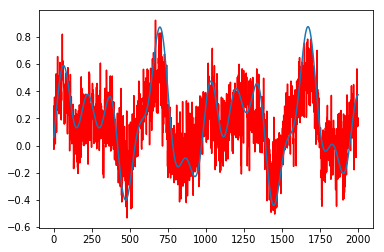

In [130]:
# plt.scatter(range(2000), predict, s = 1, c = "r")
plt.plot(range(2000), predict, c = "r")

plt.plot(Y[-2000:])